In [249]:
import seaborn as sns
df = sns.load_dataset("iris")

df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
104,6.5,3.0,5.8,2.2,virginica
110,6.5,3.2,5.1,2.0,virginica
149,5.9,3.0,5.1,1.8,virginica
21,5.1,3.7,1.5,0.4,setosa
85,6.0,3.4,4.5,1.6,versicolor


We'll focus on two attributes, since we can easily visualize.

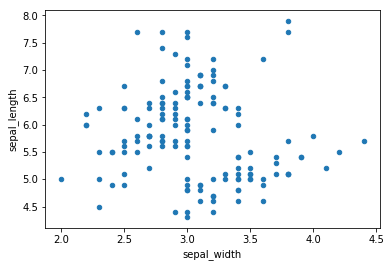

In [250]:
cols = ["sepal_width", "sepal_length"]

p = df.plot.scatter(*cols)

Let's use the number of species as the number of clusters for KMeans.

In [251]:
k = df.species.nunique()

# Implement KMeans from scratch

The algorithm is as follows. First, take k random data points as initial centroids. Then, until position of the centroids converge or a maximum number of iterations is reached:
-  For each data point, compute distance with each centroid, and assign closest.
-  For each custer, compute mean of data points.

In [252]:
import numpy as np
import pandas as pd

class KMeans():
    
    def __init__(self, k):
        self.k = k
        self.epsilon = 10**(-3)
        self.itermax = 100
    
    def distance(self, a, b):
        """
        Compute distance between a data point, and all centroids.
        Return as a pandas series.
        """
        dist = np.linalg.norm(a.values-b.values, axis=1)
        dist = pd.Series(dist, index=b.index)
        return dist
    
    def sample(self, data):
        return data.sample(self.k)

    def find_clusters(self, data, centroids):
        """
        For each data point,
            Compute distance with each centroid,
            Assign closest centroid.
        """
        return pd.DataFrame([
                self.distance(data.loc[[i],:], centroids).idxmin()
                for i in range(len(data))
            ], index=data.index)
    
    @staticmethod
    def update_centroids(data, group="clusters"):
        """
        Group data points by clusters, and sort by cluster number.
        """
        cols = [c for c in data.columns if c != group]
        return data.groupby(group).mean().reset_index(col_level=-1)\
            .sort_values(group).reset_index(drop=True)[cols]
    
    def fit(self, data):
        
        self.data = data
        cols = data.columns
        
        # Pick random centroids
        c_old = self.sample(data).reset_index(drop=True)

        i = 0
        while True:
            
            # Find clusters for each data point
            data["clusters"] = self.find_clusters(data[cols], c_old)
            
            # Update centroids
            c_new = self.update_centroids(data)
            
            # Verify convergence of centroids
            i += 1
            if self.distance(c_new, c_old).max() < self.epsilon or i >= self.itermax:
                break
                
            c_old = c_new
        
        self.n_iter = i
        self.centroids = c_new
        
        return self
    
    def predict(self, data):
        return self.find_clusters(data, self.centroids)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


15

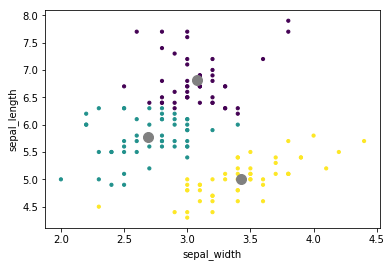

In [253]:
import pylab as plt

cols = ["sepal_width", "sepal_length"]

data = df[cols]
kmeans = KMeans(k).fit(data)

fig, ax = plt.subplots()

p1 = data.plot.scatter(*cols, c="clusters", s=10, colormap='viridis', ax=ax, colorbar=False)
p2 = kmeans.centroids.plot.scatter(*cols, s=100, c="Gray", ax=ax, colorbar=False)

kmeans.n_iter

# Compare with KMeans from sklearn

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


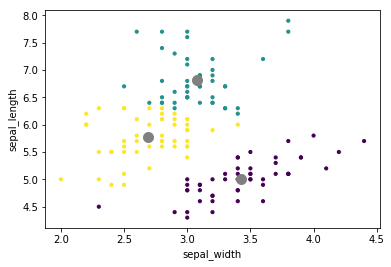

In [254]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(data[cols])
data["clusters"] = kmeans.predict(df[cols])
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cols)

fig, ax = plt.subplots()

p1 = data.plot.scatter(*cols, c="clusters", s=10, colormap='viridis', ax=ax, colorbar=False)
p2 = centroids.plot.scatter(*cols, s=100, c="Gray", ax=ax, colorbar=False)